# Simple event plotting of CNN mPMT dataset with segmentation

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
print(os.getcwd())
sys.path.append('/home/nprouse/WatChMaL/WatChMaL_analysis/')
sys.path.append('/home/nprouse/WatChMaL/WatChMaL_analysis/WatChMaL')

/home/nprouse/WatChMaL/WatChMaL_analysis/event_plotting


In [4]:
from watchmal.dataset.cnn_mpmt.cnn_mpmt_segmentation_dataset import CNNmPMTSegmentationDataset
from watchmal.dataset.h5_dataset import H5Dataset, H5TrueDataset
from watchmal.dataset.DigiTruthMapping import DigiTruthMapping

In [5]:
from omegaconf import OmegaConf

In [6]:
# Create mapping if not already created

digi_dataset = H5Dataset(h5_path='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5',
                         is_distributed=False)
true_dataset = H5TrueDataset(h5_path='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5')
mapping = DigiTruthMapping(digi_dataset, true_dataset)

DigiTruthMapping: building map 100000 / 2868354
  time elapsed   = 00 days 00 h 00 m 00 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 200000 / 2868354
  time elapsed   = 00 days 00 h 00 m 00 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 300000 / 2868354
  time elapsed   = 00 days 00 h 00 m 00 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 400000 / 2868354
  time elapsed   = 00 days 00 h 00 m 00 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 500000 / 2868354
  time elapsed   = 00 days 00 h 00 m 00 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 600000 / 2868354
  time elapsed   = 00 days 00 h 00 m 00 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 700000 / 2868354
  time elapsed   = 00 days 00 h 00 m 01 s
  remaining time = 00 days 00 h 00 m 03 s
DigiTruthMapping: building map 800000 / 2868354
  time elapsed   = 00 days 0

In [7]:
def channel_to_position(channel):
    channel = channel % 19 
    theta = (channel<12)*2*np.pi*channel/12 + ((channel >= 12) & (channel<18))*2*np.pi*(channel-12)/6
    radius = 0.2*(channel<18)+0.2*(channel<12)
    position = [radius*np.cos(theta), radius*np.sin(theta)] # note this is [y, x] or [row, column]
    return position

In [8]:
def plot_event(data, mpmt_pos, old_convention=False, **plot_args):
    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(111)
    mpmts = ax.scatter(mpmt_pos[:, 1], mpmt_pos[:, 0], s=380, facecolors='none', edgecolors='0.9')
    indices = np.indices(data.shape)
    channels = indices[0].flatten()
    positions = indices[1:].reshape(2,-1).astype(np.float64)
    positions += channel_to_position(channels)
    if old_convention:
        positions[1] = max(mpmt_pos[:, 1])-positions[1]
    pmts = ax.scatter(positions[1], positions[0], c=data.flatten(), s=3, **plot_args)
    plt.colorbar(pmts)

## Loading data and plotting test event using the "max" method

In [9]:
digi_dataset_conf = OmegaConf.create({
    "_target_" : "watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset.CNNmPMTDataset",
    "h5file" : "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5",
    "mpmt_positions_file" : "/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz",
    "collapse_arrays" : False,
    "is_distributed" : False})

In [10]:
dataset_max = CNNmPMTSegmentationDataset(
    digi_dataset_config=digi_dataset_conf,
    true_hits_h5file='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5',
    digi_truth_mapping_file='truth_for_data.pkl',
    parent_type="max")

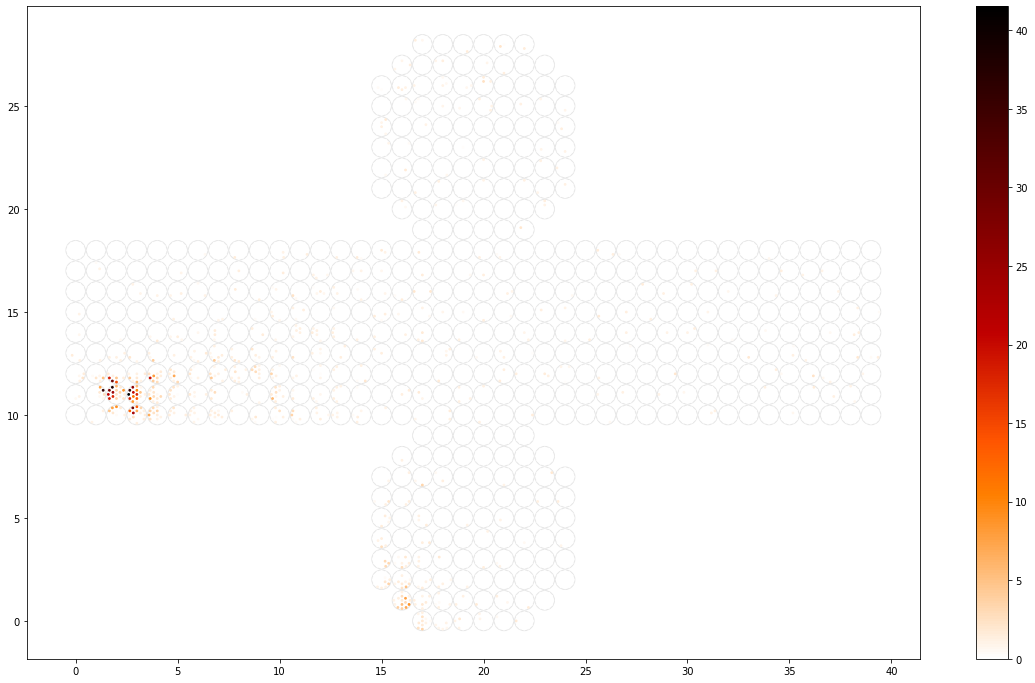

In [11]:
event = dataset_max.__getitem__(100013)
data = event['data']
plot_event(data, dataset_max.digi_dataset.mpmt_positions, cmap=plt.cm.gist_heat_r)

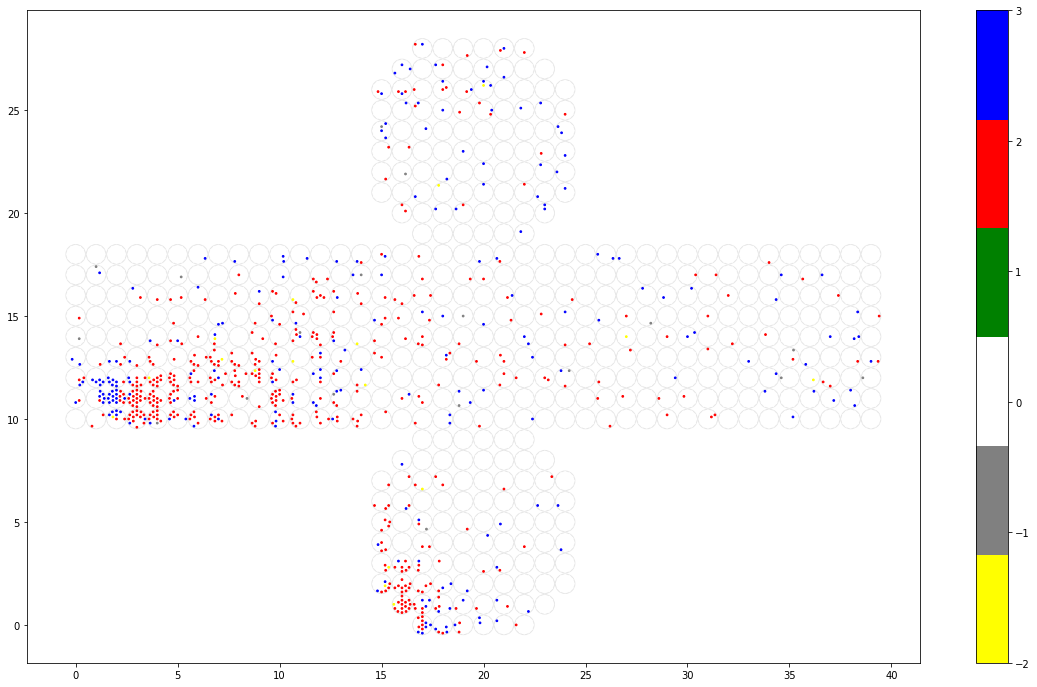

In [12]:
segmentation = event['segmentation']
plot_event(segmentation, dataset_max.digi_dataset.mpmt_positions,
           cmap=ListedColormap(["yellow", "gray", "white", "green", "red", "blue"]))

In [13]:
item = 1000000
truthitem = dataset_max.digi_truth_mapping[item]
print(item,
      dataset_max.digi_dataset.__getitem__(item)['event_ids'],
      dataset_max.digi_dataset.__getitem__(item)['root_files'])
print(truthitem,
      dataset_max.truth_dataset.__getitem__(truthitem)['event_ids'],
      dataset_max.truth_dataset.__getitem__(truthitem)['root_files'])

1000000 2047 b'/localscratch/prouse.57185384.0/WCSim/pi0/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_413.root'
1046047 2047 b'/localscratch/prouse.57185384.0/WCSim/pi0/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_413.root'


### Profile speed for loading 1000 events

In [14]:
%%time
for i in range(1000):
    dataset_max.__getitem__(i)

CPU times: user 934 ms, sys: 14.7 ms, total: 949 ms
Wall time: 951 ms


## Profile speed for loading and processing 10000 events

In [15]:
%%time
counts = {
    -2: 0,
    -1: 0,
     0: 0,
     2: 0,
     3: 0
}
for i in range(10000):
    segmentation = dataset_max.__getitem__(i)['segmentation']
    for p in (-2, -1, 0, 2, 3):
        counts[p] += np.count_nonzero(segmentation==p)
for k, v in counts.items():
    print(v, "entries have parent ID", k)
print(100*counts[-2]/sum(counts[k] for k in (-2, -1, 2, 3)), "% of hits have more than one parent (only method)",
      "or more than one parent contributing equally (max method)")

936130 entries have parent ID -2
117322 entries have parent ID -1
204304446 entries have parent ID 0
7565920 entries have parent ID 2
7476182 entries have parent ID 3
5.816078154253032 % of hits have more than one parent (only method) or more than one parent contributing equally (max method)
CPU times: user 9.91 s, sys: 99.7 ms, total: 10 s
Wall time: 10 s


## Loading data and plotting test event using the "only" method

In [16]:
dataset_only = CNNmPMTSegmentationDataset(
    digi_dataset_config=digi_dataset_conf,
    true_hits_h5file='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5',
    digi_truth_mapping_file='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truth_for_data.pkl',
    parent_type="only")

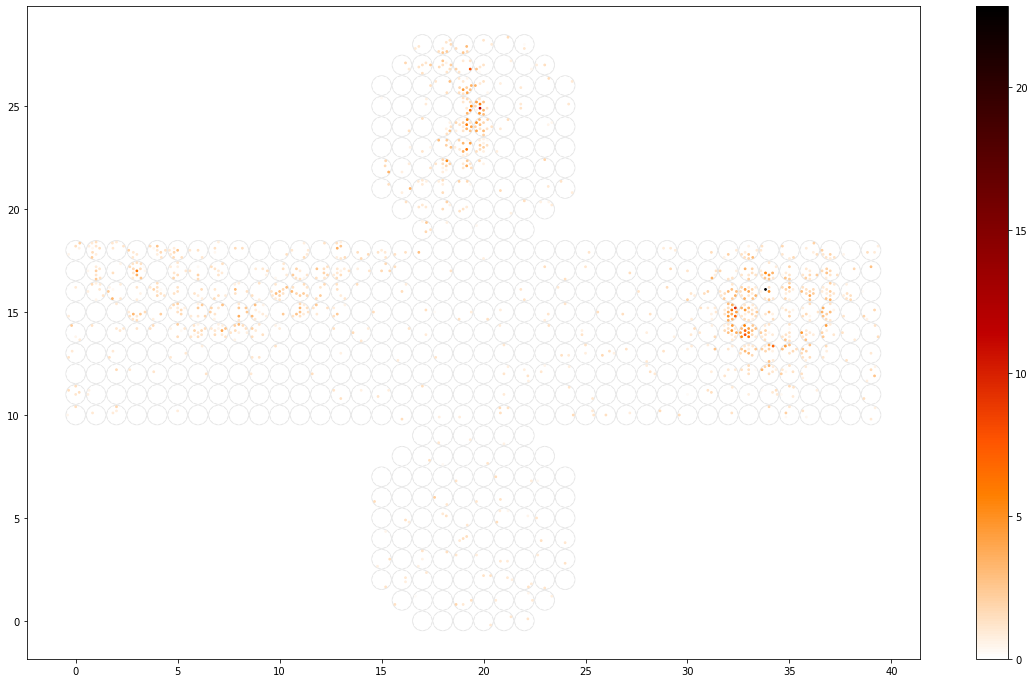

In [17]:
event = dataset_only.__getitem__(2)
data = event['data']
plot_event(data, dataset_only.digi_dataset.mpmt_positions, cmap=plt.cm.gist_heat_r)

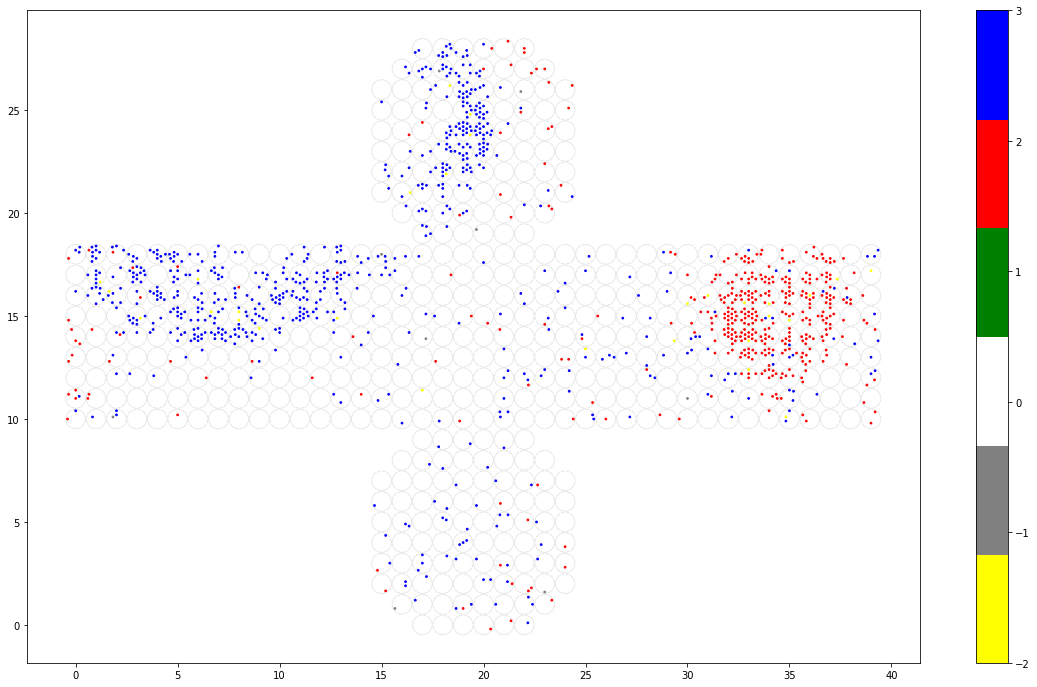

In [18]:
segmentation = event['segmentation']
plot_event(segmentation, dataset_only.digi_dataset.mpmt_positions,
           cmap=ListedColormap(["yellow", "gray", "white", "green", "red", "blue"]))

In [19]:
# Count the number of digitised hits assigned as each parent ID using the only / max method
# -2 : hits with more than one parent / more than one parent contributing equally
# -1 : hits with only / mostly dark noise
#  0 : unhit PMTs (this includes spaces in the image where there is no PMT)
#  2 : hits with parent only / mostly from pion decay gamma assigned as particle ID 2
#  3 : hits with parent only / mostly from pion decay gamma assigned as particle ID 3
# Note: true hits with parents other than -1, 2 or 3 are ignored
for p in (-2, -1, 0, 2, 3):
    print(np.count_nonzero(segmentation==p), "entries have parent ID", p)

29 entries have parent ID -2
9 entries have parent ID -1
20918 entries have parent ID 0
411 entries have parent ID 2
673 entries have parent ID 3


## Profile speed for loading and processing 10000 events

In [20]:
%%time
counts = {
    -2: 0,
    -1: 0,
     0: 0,
     2: 0,
     3: 0
}
for i in range(10000):
    segmentation = dataset_only.__getitem__(i)['segmentation']
    for p in (-2, -1, 0, 2, 3):
        counts[p] += np.count_nonzero(segmentation==p)
for k, v in counts.items():
    print(v, "entries have parent ID", k)
print(100*counts[-2]/sum(counts[k] for k in (-2, -1, 2, 3)), "% of hits have more than one parent (only method)",
      "or more than one parent contributing equally (max method)")

2123447 entries have parent ID -2
223319 entries have parent ID -1
204304446 entries have parent ID 0
6916795 entries have parent ID 2
6831993 entries have parent ID 3
13.192754968235327 % of hits have more than one parent (only method) or more than one parent contributing equally (max method)
CPU times: user 10.7 s, sys: 32.5 ms, total: 10.7 s
Wall time: 10.7 s
